In [71]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Basic stats

In [72]:
!cat first_names_50k.txt | sort | uniq -c | wc -l

   10708


In [73]:
!awk 'NF>1' /Users/leannchen/ppl-crawl/first_names_50k.txt | head -20

In [74]:
## Clean First Names Data

# Read the first names file
print("Loading first names data...")
with open('first_names_50k.txt', 'r') as f:
    raw_names = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(raw_names):,} raw first names")

def clean_first_name(name):
    """
    Clean a first name by:
    1. Extracting first part before dots (e.g., 'john.b.hillenbrand' -> 'john')
    2. Removing non-alphabetic characters
    3. Filtering out single characters, initials, and common prefixes
    4. Normalizing case
    """
    if not name or not isinstance(name, str):
        return None
    
    name = name.strip()
    if not name:
        return None
    
    # Split on dots and take the first part (handles 'john.b.hillenbrand' -> 'john')
    if '.' in name:
        name = name.split('.')[0]
    
    # Remove common prefixes/titles
    prefixes = ['dr', 'mr', 'ms', 'mrs', 'prof', 'sir', 'dame']
    name_lower = name.lower()
    for prefix in prefixes:
        if name_lower.startswith(prefix) and len(name) > len(prefix) + 1:
            # Check if it's actually a prefix (followed by space/dot or end of string)
            if name_lower == prefix or name_lower[len(prefix):len(prefix)+1] in ['.', ' ']:
                # Extract the part after prefix
                remaining = name[len(prefix):].lstrip('. ')
                if remaining:
                    name = remaining
                    break
    
    # Remove all non-alphabetic characters (keeps only letters)
    cleaned = re.sub(r'[^a-zA-Z]', '', name)
    
    # Filter out invalid names:
    # - Single characters (like 'Y', 'S')
    # - Too short (less than 2 characters)
    # - Too long (likely not a first name, > 20 chars)
    if len(cleaned) < 2 or len(cleaned) > 20:
        return None
    
    # Title case (first letter uppercase, rest lowercase)
    return cleaned.title()

# Clean all names
print("\nCleaning names...")
cleaned_names = []
for name in raw_names:
    cleaned = clean_first_name(name)
    if cleaned:
        cleaned_names.append(cleaned)

print(f"Cleaned {len(cleaned_names):,} valid first names")
print(f"Filtered out {len(raw_names) - len(cleaned_names):,} invalid names ({100*(len(raw_names) - len(cleaned_names))/len(raw_names):.1f}%)")

# Show examples of cleaned names
print("\nSample cleaned names:")
for name in cleaned_names[:20]:
    print(f"  {name}")

# Show examples of filtered names
print("\nSample filtered names (before cleaning):")
filtered_examples = [name for name in raw_names if not clean_first_name(name)][:20]
for name in filtered_examples:
    print(f"  {name}")

# Count unique cleaned names
unique_cleaned = len(set(cleaned_names))
print(f"\nUnique cleaned names: {unique_cleaned:,}")
print(f"Total cleaned names: {len(cleaned_names):,}")
print(f"Average occurrences per unique name: {len(cleaned_names)/unique_cleaned:.2f}")

# Export cleaned names to file with summary
output_file = 'first_names_50k_cleaned.txt'
print(f"\nExporting cleaned names to {output_file}...")

with open(output_file, 'w') as f:
    # Write summary header
    f.write("=" * 80 + "\n")
    f.write("CLEANED FIRST NAMES DATASET\n")
    f.write("=" * 80 + "\n\n")
    f.write("SUMMARY:\n")
    f.write(f"  - Total raw names processed: {len(raw_names):,}\n")
    f.write(f"  - Valid cleaned names: {len(cleaned_names):,}\n")
    f.write(f"  - Invalid names filtered: {len(raw_names) - len(cleaned_names):,} ({100*(len(raw_names) - len(cleaned_names))/len(raw_names):.1f}%)\n")
    f.write(f"  - Unique cleaned names: {unique_cleaned:,}\n")
    f.write(f"  - Average occurrences per unique name: {len(cleaned_names)/unique_cleaned:.2f}\n\n")
    f.write("CLEANING RULES APPLIED:\n")
    f.write("  1. Extracted first part before dots (e.g., 'john.b.hillenbrand' -> 'john')\n")
    f.write("  2. Removed common prefixes/titles (Dr., Mr., Ms., etc.)\n")
    f.write("  3. Removed all non-alphabetic characters\n")
    f.write("  4. Filtered out single characters, initials, and names < 2 or > 20 characters\n")
    f.write("  5. Normalized to title case\n\n")
    f.write("=" * 80 + "\n")
    f.write("CLEANED NAMES (one per line):\n")
    f.write("=" * 80 + "\n\n")
    
    # Write cleaned names (one per line)
    for name in cleaned_names:
        f.write(name + '\n')

print(f"✅ Successfully exported {len(cleaned_names):,} cleaned names to {output_file}")
print(f"   File includes summary header with statistics")


Loading first names data...
Loaded 50,000 raw first names

Cleaning names...
Cleaned 49,706 valid first names
Filtered out 294 invalid names (0.6%)

Sample cleaned names:
  Sundar
  Sam
  Bill
  Markus
  Steve
  Stephanie
  Bernie
  Bridgit
  Ben
  David
  Elon
  Hillary
  Andrew
  Gautam
  Mark
  Joe
  Mike
  Jeff
  Barack
  Pete

Sample filtered names (before cleaning):
  Y.
  S.
  A.G.
  J.
  R.
  H.
  O.B.
  W.
  D.A.
  C.
  S
  B.J.
  M.
  J
  J.
  H.-S.
  C.
  F.
  S.
  E.

Unique cleaned names: 10,522
Total cleaned names: 49,706
Average occurrences per unique name: 4.72

Exporting cleaned names to first_names_50k_cleaned.txt...
✅ Successfully exported 49,706 cleaned names to first_names_50k_cleaned.txt
   File includes summary header with statistics


In [ ]:
# IMPROVED: Chunk-based US Name Classification with LLM
# This approach processes names in small batches to avoid context limits
# and maintains reproducibility by saving progress

import json
import os
from pathlib import Path

# Configuration
CHUNK_SIZE = 250  # Process 250 names at a time
PROGRESS_FILE = 'name_classification_progress.json'
CLASSIFIED_FILE = 'name_classifications_final.json'

# Load previously classified names if they exist (for resume capability)
if os.path.exists(PROGRESS_FILE):
    print(f"📂 Loading existing progress from {PROGRESS_FILE}...")
    with open(PROGRESS_FILE, 'r') as f:
        progress_data = json.load(f)
        classified_names = progress_data.get('classified_names', {})
        last_processed_line = progress_data.get('last_processed_line', 0)
    print(f"   Resuming from line {last_processed_line}")
    print(f"   Already classified: {len(classified_names)} names")
else:
    classified_names = {}
    last_processed_line = 0
    print("🆕 Starting fresh classification")

# Read the names file
print(f"\n📖 Reading names from first_names_50k_cleaned.txt...")
with open('first_names_50k_cleaned.txt', 'r') as f:
    all_lines = f.readlines()

# Skip header (lines before the actual names start)
names_start_line = 0
for i, line in enumerate(all_lines):
    if line.strip() and not line.startswith('=') and not any(x in line for x in ['SUMMARY:', 'CLEANING', '  -', 'Total raw', 'Valid cleaned', 'Invalid', 'Unique', 'Average', 'Extracted', 'Removed', 'Filtered', 'Normalized', 'CLEANED NAMES']):
        names_start_line = i
        break

names_lines = [line.strip() for line in all_lines[names_start_line:] if line.strip()]
print(f"   Found {len(names_lines)} names to process")

# Create unique name list
unique_names = sorted(list(set(names_lines)))
print(f"   Unique names: {len(unique_names)}")

# Filter out already classified names
remaining_names = [name for name in unique_names if name not in classified_names]
print(f"   Remaining to classify: {len(remaining_names)}")

if len(remaining_names) == 0:
    print("\n✅ All names already classified!")
else:
    print(f"\n🔄 Will process {len(remaining_names)} names in chunks of {CHUNK_SIZE}")
    print(f"   Total chunks: {(len(remaining_names) + CHUNK_SIZE - 1) // CHUNK_SIZE}")
    print("\n⚠️  To proceed with LLM classification, run the next cell...")

# Parse US names reference for baseline
print("\n📚 Loading existing US names reference for comparison...")
try:
    with open('common_us_names.txt', 'r') as f:
        reference_content = f.read()
    
    # Parse sections
    lines = reference_content.split('\n')
    male_names = set()
    female_names = set()
    unisex_names = set()
    
    current_section = None
    for raw in lines:
        line = raw.strip()
        if not line:
            continue
        
        lower = line.lower()
        if ('male' in lower and 'name' in lower) and not ('female' in lower):
            current_section = 'male'
            continue
        if 'female' in lower and 'name' in lower:
            current_section = 'female'
            continue
        if ('unisex' in lower) or ('gender' in lower and 'neutral' in lower):
            current_section = 'unisex'
            continue
        if lower.startswith(('summary', 'updated summary', 'note', 'comprehensive', 'common us', 'total')):
            current_section = None
            continue
        
        if current_section in {'male', 'female', 'unisex'}:
            name = line.strip()
            if name.endswith(':'):
                continue
            if current_section == 'male':
                male_names.add(name)
            elif current_section == 'female':
                female_names.add(name)
            else:
                unisex_names.add(name)
    
    all_us_names = male_names | female_names | unisex_names
    print(f"   Loaded reference: {len(male_names)} male, {len(female_names)} female, {len(unisex_names)} unisex")
    
except FileNotFoundError:
    print("   ⚠️  common_us_names.txt not found, will rely solely on LLM")
    all_us_names = set()
    male_names = set()
    female_names = set()
    unisex_names = set()

In [80]:
# LLM-based Name Classification (Chunk Processing)
# This cell performs the actual classification using an LLM API

import anthropic
import time
import os
from tqdm.auto import tqdm

# Try to load from .env file if it exists
try:
    from dotenv import load_dotenv
    load_dotenv()
    print("✅ Loaded environment from .env file")
except ImportError:
    print("ℹ️  python-dotenv not installed. Install with: pip install python-dotenv")
except Exception:
    pass

# Check if API key is set
if not os.environ.get('ANTHROPIC_API_KEY'):
    print("❌ ANTHROPIC_API_KEY not found!")
    print("\nTo fix this, choose one option:")
    print("\n1. Set it in this notebook (add a cell before this one):")
    print("   import os")
    print("   os.environ['ANTHROPIC_API_KEY'] = 'your-api-key-here'")
    print("\n2. Set it in terminal before starting Jupyter:")
    print("   export ANTHROPIC_API_KEY='your-api-key-here'")
    print("\n3. Create a .env file with:")
    print("   ANTHROPIC_API_KEY=your-api-key-here")
    print("\nGet your API key from: https://console.anthropic.com/settings/keys")
    raise ValueError("ANTHROPIC_API_KEY environment variable not set")

# Initialize Claude API client
try:
    client = anthropic.Anthropic()
    print("✅ Claude API client initialized")
except Exception as e:
    print(f"❌ Failed to initialize Claude API: {e}")
    raise

def classify_name_chunk(names_chunk):
    """
    Classify a chunk of names using Claude API
    Returns: dict mapping name -> {gender, us_common, confidence}
    """
    names_list = "\n".join([f"{i+1}. {name}" for i, name in enumerate(names_chunk)])
    
    prompt = f"""You are a name classification expert. Classify each of the following {len(names_chunk)} first names.

For each name, determine:
1. **Gender**: "male", "female", or "unisex"
2. **US Common**: "yes" if it's commonly used in the United States, "no" if it's rare/foreign
3. **Confidence**: "high", "medium", or "low"

Names to classify:
{names_list}

Return your response as a JSON array with this exact format:
[
  {{"name": "Example", "gender": "male", "us_common": "yes", "confidence": "high"}},
  ...
]

Guidelines:
- Base gender on typical usage patterns
- "unisex" means the name is commonly used for both genders
- "US common" means the name appears frequently in US naming data
- Consider cultural/linguistic origins
- Be consistent and deterministic

Return ONLY the JSON array, no other text."""

    try:
        message = client.messages.create(
            model="claude-sonnet-4-5",
            max_tokens=4000,
            messages=[{"role": "user", "content": prompt}]
        )
        
        response_text = message.content[0].text.strip()
        
        # Parse JSON response
        # Remove markdown code blocks if present
        if response_text.startswith('```'):
            response_text = '\n'.join(response_text.split('\n')[1:-1])
        
        classifications = json.loads(response_text)
        
        # Convert to dict format
        result = {}
        for item in classifications:
            name = item.get('name')
            if name:
                result[name] = {
                    'gender': item.get('gender', 'unknown'),
                    'us_common': item.get('us_common', 'no'),
                    'confidence': item.get('confidence', 'low')
                }
        
        return result
    
    except Exception as e:
        print(f"\n❌ Error classifying chunk: {e}")
        print(f"   Response: {response_text[:200] if 'response_text' in locals() else 'N/A'}")
        return {}

# Process remaining names in chunks
if len(remaining_names) > 0:
    print(f"\n🚀 Starting chunk-based classification...")
    print(f"   Processing {len(remaining_names)} names in chunks of {CHUNK_SIZE}")
    print(f"   This will make ~{(len(remaining_names) + CHUNK_SIZE - 1) // CHUNK_SIZE} API calls\n")
    
    # Process in chunks with progress bar
    total_chunks = (len(remaining_names) + CHUNK_SIZE - 1) // CHUNK_SIZE
    
    for chunk_idx in tqdm(range(0, len(remaining_names), CHUNK_SIZE), desc="Classifying chunks"):
        chunk = remaining_names[chunk_idx:chunk_idx + CHUNK_SIZE]
        chunk_num = chunk_idx // CHUNK_SIZE + 1
        
        print(f"\n📦 Chunk {chunk_num}/{total_chunks}: Processing {len(chunk)} names...")
        
        # Classify this chunk
        chunk_results = classify_name_chunk(chunk)
        
        # Update classified_names
        classified_names.update(chunk_results)
        
        # Save progress after each chunk
        progress_data = {
            'classified_names': classified_names,
            'last_processed_line': chunk_idx + len(chunk),
            'total_classified': len(classified_names),
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }
        
        with open(PROGRESS_FILE, 'w') as f:
            json.dump(progress_data, f, indent=2)
        
        print(f"   ✅ Classified {len(chunk_results)} names (Total: {len(classified_names)})")
        print(f"   💾 Progress saved to {PROGRESS_FILE}")
        
        # Rate limiting: small delay between chunks
        if chunk_idx + CHUNK_SIZE < len(remaining_names):
            time.sleep(1)
    
    print(f"\n🎉 Classification complete!")
    print(f"   Total names classified: {len(classified_names)}")
    
    # Save final results
    with open(CLASSIFIED_FILE, 'w') as f:
        json.dump(classified_names, f, indent=2)
    
    print(f"   💾 Final results saved to {CLASSIFIED_FILE}")

else:
    print("\n✅ No remaining names to classify")

# Display classification summary
print(f"\n{'='*60}")
print("CLASSIFICATION SUMMARY:")
print(f"{'='*60}")

gender_counts = {'male': 0, 'female': 0, 'unisex': 0, 'unknown': 0}
us_common_counts = {'yes': 0, 'no': 0}
confidence_counts = {'high': 0, 'medium': 0, 'low': 0}

for name, info in classified_names.items():
    gender_counts[info.get('gender', 'unknown')] = gender_counts.get(info.get('gender', 'unknown'), 0) + 1
    us_common_counts[info.get('us_common', 'no')] = us_common_counts.get(info.get('us_common', 'no'), 0) + 1
    confidence_counts[info.get('confidence', 'low')] = confidence_counts.get(info.get('confidence', 'low'), 0) + 1

print(f"\nTotal classified: {len(classified_names)}")
print(f"\nGender distribution:")
for gender, count in gender_counts.items():
    if count > 0:
        print(f"  {gender.capitalize():10s}: {count:,} ({count/len(classified_names)*100:.1f}%)")

print(f"\nUS Common:")
for status, count in us_common_counts.items():
    if count > 0:
        print(f"  {status.capitalize():10s}: {count:,} ({count/len(classified_names)*100:.1f}%)")

print(f"\nConfidence:")
for conf, count in confidence_counts.items():
    if count > 0:
        print(f"  {conf.capitalize():10s}: {count:,} ({count/len(classified_names)*100:.1f}%)")

✅ Loaded environment from .env file
✅ Claude API client initialized

🚀 Starting chunk-based classification...
   Processing 10537 names in chunks of 250
   This will make ~43 API calls



Classifying chunks:   0%|          | 0/43 [00:00<?, ?it/s]


📦 Chunk 1/43: Processing 250 names...

❌ Error classifying chunk: Expecting value: line 131 column 85 (char 10702)
   Response: [
  {"name": "Aabria", "gender": "female", "us_common": "no", "confidence": "medium"},
  {"name": "Aad", "gender": "male", "us_common": "no", "confidence": "high"},
  {"name": "Aakrit", "gender": "mal
   ✅ Classified 0 names (Total: 0)
   💾 Progress saved to name_classification_progress.json

📦 Chunk 2/43: Processing 250 names...

❌ Error classifying chunk: Expecting value: line 134 column 81 (char 10988)
   Response: [
  {"name": "Alahdal", "gender": "male", "us_common": "no", "confidence": "low"},
  {"name": "Alain", "gender": "male", "us_common": "no", "confidence": "high"},
  {"name": "Alaina", "gender": "femal
   ✅ Classified 0 names (Total: 0)
   💾 Progress saved to name_classification_progress.json

📦 Chunk 3/43: Processing 250 names...

❌ Error classifying chunk: Expecting value: line 132 column 80 (char 10882)
   Response: [
  {"name": "Anders", "gen

KeyboardInterrupt: 

In [ ]:
# Integrate classified names into analysis
# Load the final classifications and prepare for downstream analysis

print("📊 Loading classified names for analysis...")

# Load classifications (either from progress or final file)
if os.path.exists(CLASSIFIED_FILE):
    with open(CLASSIFIED_FILE, 'r') as f:
        classified_names = json.load(f)
    print(f"   Loaded {len(classified_names)} classifications from {CLASSIFIED_FILE}")
elif os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE, 'r') as f:
        progress_data = json.load(f)
        classified_names = progress_data.get('classified_names', {})
    print(f"   Loaded {len(classified_names)} classifications from {PROGRESS_FILE} (in progress)")
else:
    print("   ❌ No classification file found. Please run the classification cell first.")
    classified_names = {}

# Build the male_names, female_names, unisex_names sets from LLM classifications
male_names = set()
female_names = set()
unisex_names = set()
us_common_names = set()

for name, info in classified_names.items():
    gender = info.get('gender', 'unknown')
    us_common = info.get('us_common', 'no')
    
    if gender == 'male':
        male_names.add(name)
    elif gender == 'female':
        female_names.add(name)
    elif gender == 'unisex':
        unisex_names.add(name)
    
    if us_common == 'yes':
        us_common_names.add(name)

all_us_names = us_common_names

print(f"\nParsed classifications:")
print(f"  Male names: {len(male_names)}")
print(f"  Female names: {len(female_names)}")
print(f"  Unisex names: {len(unisex_names)}")
print(f"  US common names: {len(us_common_names)}")

# Create summary statistics
print(f"\nClassification quality metrics:")
high_conf = sum(1 for info in classified_names.values() if info.get('confidence') == 'high')
medium_conf = sum(1 for info in classified_names.values() if info.get('confidence') == 'medium')
low_conf = sum(1 for info in classified_names.values() if info.get('confidence') == 'low')

print(f"  High confidence: {high_conf} ({high_conf/len(classified_names)*100:.1f}%)")
print(f"  Medium confidence: {medium_conf} ({medium_conf/len(classified_names)*100:.1f}%)")
print(f"  Low confidence: {low_conf} ({low_conf/len(classified_names)*100:.1f}%)")

print(f"\n✅ Ready for name analysis!")
print("   Variables available:")
print("   - male_names: set of male first names")
print("   - female_names: set of female first names")
print("   - unisex_names: set of unisex first names")
print("   - all_us_names: set of US common names")
print("   - classified_names: dict with full classification details")

## Name Extraction and Cleaning

In [42]:
def extract_first_name(full_name):
    """Extract and clean the first name from a full name"""
    if not full_name or pd.isna(full_name):
        return None
    
    # Handle various name formats
    name_parts = str(full_name).strip().split()
    if not name_parts:
        return None
    
    first_part = name_parts[0]
    
    # Remove common prefixes/titles
    prefixes = ['Dr.', 'Dr', 'Mr.', 'Mr', 'Ms.', 'Ms', 'Mrs.', 'Mrs', 'Prof.', 'Prof', 'Sir', 'Dame']
    if first_part in prefixes and len(name_parts) > 1:
        first_part = name_parts[1]
    
    # Clean up punctuation and keep only letters
    first_name = re.sub(r'[^a-zA-Z]', '', first_part)
    
    return first_name.title() if first_name and len(first_name) > 1 else None

# Extract all first names
print("Extracting first names...")
first_names = []
valid_entities = []

for entity in entities:
    first_name = extract_first_name(entity.get('name', ''))
    if first_name:
        first_names.append(first_name)
        valid_entities.append(entity)

print(f"Extracted {len(first_names):,} valid first names from {len(entities):,} entities")
print(f"Filtered out {len(entities) - len(first_names):,} entities with invalid names")

# Create DataFrame
df = pd.DataFrame({
    'full_name': [e.get('name', '') for e in valid_entities],
    'first_name': first_names,
    'image': [e.get('image', '') for e in valid_entities]
})

print(f"\nDataset shape: {df.shape}")
display(df.head())

Extracting first names...
Extracted 29,821 valid first names from 30,000 entities
Filtered out 179 entities with invalid names

Dataset shape: (29821, 3)


,full_name,first_name,image
0,Bill Gates,Bill,https://kg.diffbot.com/image/api/get?fetch=yes...
1,Sundar Pichai,Sundar,https://kg.diffbot.com/image/api/get?fetch=yes...
2,Sam Altman,Sam,https://kg.diffbot.com/image/api/get?fetch=yes...
3,Markus Persson,Markus,https://kg.diffbot.com/image/api/get?fetch=yes...
4,Steve Wozniak,Steve,https://kg.diffbot.com/image/api/get?fetch=yes...


## Analysis 1: Unique Name Distribution

First, let's analyze treating all names as unique entities (no variance grouping).

In [43]:
# Count name frequencies
name_counts = df['first_name'].value_counts()

print("=== UNIQUE NAME ANALYSIS ===")
print(f"Total people: {len(df):,}")
print(f"Unique first names: {len(name_counts):,}")
print(f"Average frequency per name: {len(df) / len(name_counts):.1f}")

print(f"\nTop 20 most common names:")
for i, (name, count) in enumerate(name_counts.head(20).items(), 1):
    in_ref = "✓" if name in all_us_names else "✗"
    print(f"{i:2d}. {name:12s}: {count:4d} [{in_ref}]")

=== UNIQUE NAME ANALYSIS ===
Total people: 29,821
Unique first names: 7,126
Average frequency per name: 4.2

Top 20 most common names:
 1. David       :  645 [✓]
 2. John        :  618 [✓]
 3. Michael     :  476 [✓]
 4. Mark        :  338 [✓]
 5. Peter       :  302 [✓]
 6. Robert      :  285 [✓]
 7. James       :  275 [✓]
 8. Paul        :  275 [✓]
 9. Richard     :  266 [✓]
10. Andrew      :  208 [✓]
11. Chris       :  188 [✓]
12. William     :  174 [✓]
13. Thomas      :  174 [✓]
14. Daniel      :  170 [✓]
15. Eric        :  166 [✓]
16. Scott       :  163 [✓]
17. Brian       :  162 [✓]
18. Mike        :  153 [✓]
19. Steve       :  151 [✓]
20. Kevin       :  145 [✓]


In [29]:
# Verify gender category for top 20 names and list top female names

# Table of top 20 names with gender category
top20 = name_counts.head(20)

def _name_category(n):
    if n in female_names:
        return 'Female'
    if n in male_names:
        return 'Male'
    if n in unisex_names:
        return 'Unisex'
    return 'Unknown'

verification_df = pd.DataFrame(
    [(n, c, _name_category(n)) for n, c in top20.items()],
    columns=['name', 'count', 'category']
)
display(verification_df)

# Top 20 female names by frequency in this dataset
female_counts = (
    name_counts[name_counts.index.isin(female_names)]
    .sort_values(ascending=False)
)
display(female_counts.head(20))



,name,count,category
0,David,645,Male
1,John,618,Male
2,Michael,476,Male
3,Mark,338,Male
4,Peter,302,Male
5,Robert,285,Male
6,James,275,Male
7,Paul,275,Male
8,Richard,266,Male
9,Andrew,208,Male


first_name
Susan        91
Mary         84
Jennifer     77
Elizabeth    67
Karen        67
Sarah        64
Lisa         63
Anne         60
Jane         57
Nancy        54
Laura        52
Maria        48
Barbara      45
Anna         44
Andrea       43
Amy          43
Jessica      42
Linda        42
Julie        39
Julia        39
Name: count, dtype: int64

In [44]:
# Classify names against US reference
us_names_in_data = set(name_counts.index).intersection(all_us_names)
non_us_names_in_data = set(name_counts.index) - all_us_names

# Count people (not unique names)
us_people_count = name_counts[name_counts.index.isin(all_us_names)].sum()
non_us_people_count = name_counts[name_counts.index.isin(non_us_names_in_data)].sum()

print("=== US vs NON-US CLASSIFICATION (Unique Names) ===")
print(f"Unique names in dataset: {len(name_counts):,}")
print(f"US names found: {len(us_names_in_data):,} ({len(us_names_in_data)/len(name_counts)*100:.1f}%)")
print(f"Non-US names: {len(non_us_names_in_data):,} ({len(non_us_names_in_data)/len(name_counts)*100:.1f}%)")
print()
print(f"People with US names: {us_people_count:,} ({us_people_count/len(df)*100:.1f}%)")
print(f"People with non-US names: {non_us_people_count:,} ({non_us_people_count/len(df)*100:.1f}%)")
print()
print(f"US reference coverage: {len(us_names_in_data)}/{len(all_us_names)} = {len(us_names_in_data)/len(all_us_names)*100:.1f}%")

=== US vs NON-US CLASSIFICATION (Unique Names) ===
Unique names in dataset: 7,126
US names found: 503 (7.1%)
Non-US names: 6,623 (92.9%)

People with US names: 17,192 (57.7%)
People with non-US names: 12,629 (42.3%)

US reference coverage: 503/538 = 93.5%


In [31]:
# Gender distribution (unique names)
male_names_in_data = set(name_counts.index).intersection(male_names)
female_names_in_data = set(name_counts.index).intersection(female_names)
unisex_names_in_data = set(name_counts.index).intersection(unisex_names)

male_people = name_counts[name_counts.index.isin(male_names)].sum()
female_people = name_counts[name_counts.index.isin(female_names)].sum()
unisex_people = name_counts[name_counts.index.isin(unisex_names)].sum()
unknown_people = len(df) - (male_people + female_people + unisex_people)

print("=== GENDER DISTRIBUTION (Unique Names) ===")
print(f"Male names: {len(male_names_in_data):,} unique names, {male_people:,} people ({male_people/len(df)*100:.1f}%)")
print(f"Female names: {len(female_names_in_data):,} unique names, {female_people:,} people ({female_people/len(df)*100:.1f}%)")
print(f"Unisex names: {len(unisex_names_in_data):,} unique names, {unisex_people:,} people ({unisex_people/len(df)*100:.1f}%)")
print(f"Unknown/Non-US: {len(non_us_names_in_data):,} unique names, {unknown_people:,} people ({unknown_people/len(df)*100:.1f}%)")

# Among classified genders only
classified_people = male_people + female_people
if classified_people > 0:
    male_ratio = male_people / classified_people * 100
    female_ratio = female_people / classified_people * 100
    print(f"\nAmong US-classified names: {male_ratio:.1f}% Male, {female_ratio:.1f}% Female")

=== GENDER DISTRIBUTION (Unique Names) ===
Male names: 290 unique names, 13,738 people (46.1%)
Female names: 181 unique names, 3,240 people (10.9%)
Unisex names: 11 unique names, 144 people (0.5%)
Unknown/Non-US: 6,655 unique names, 12,699 people (42.6%)

Among US-classified names: 80.9% Male, 19.1% Female


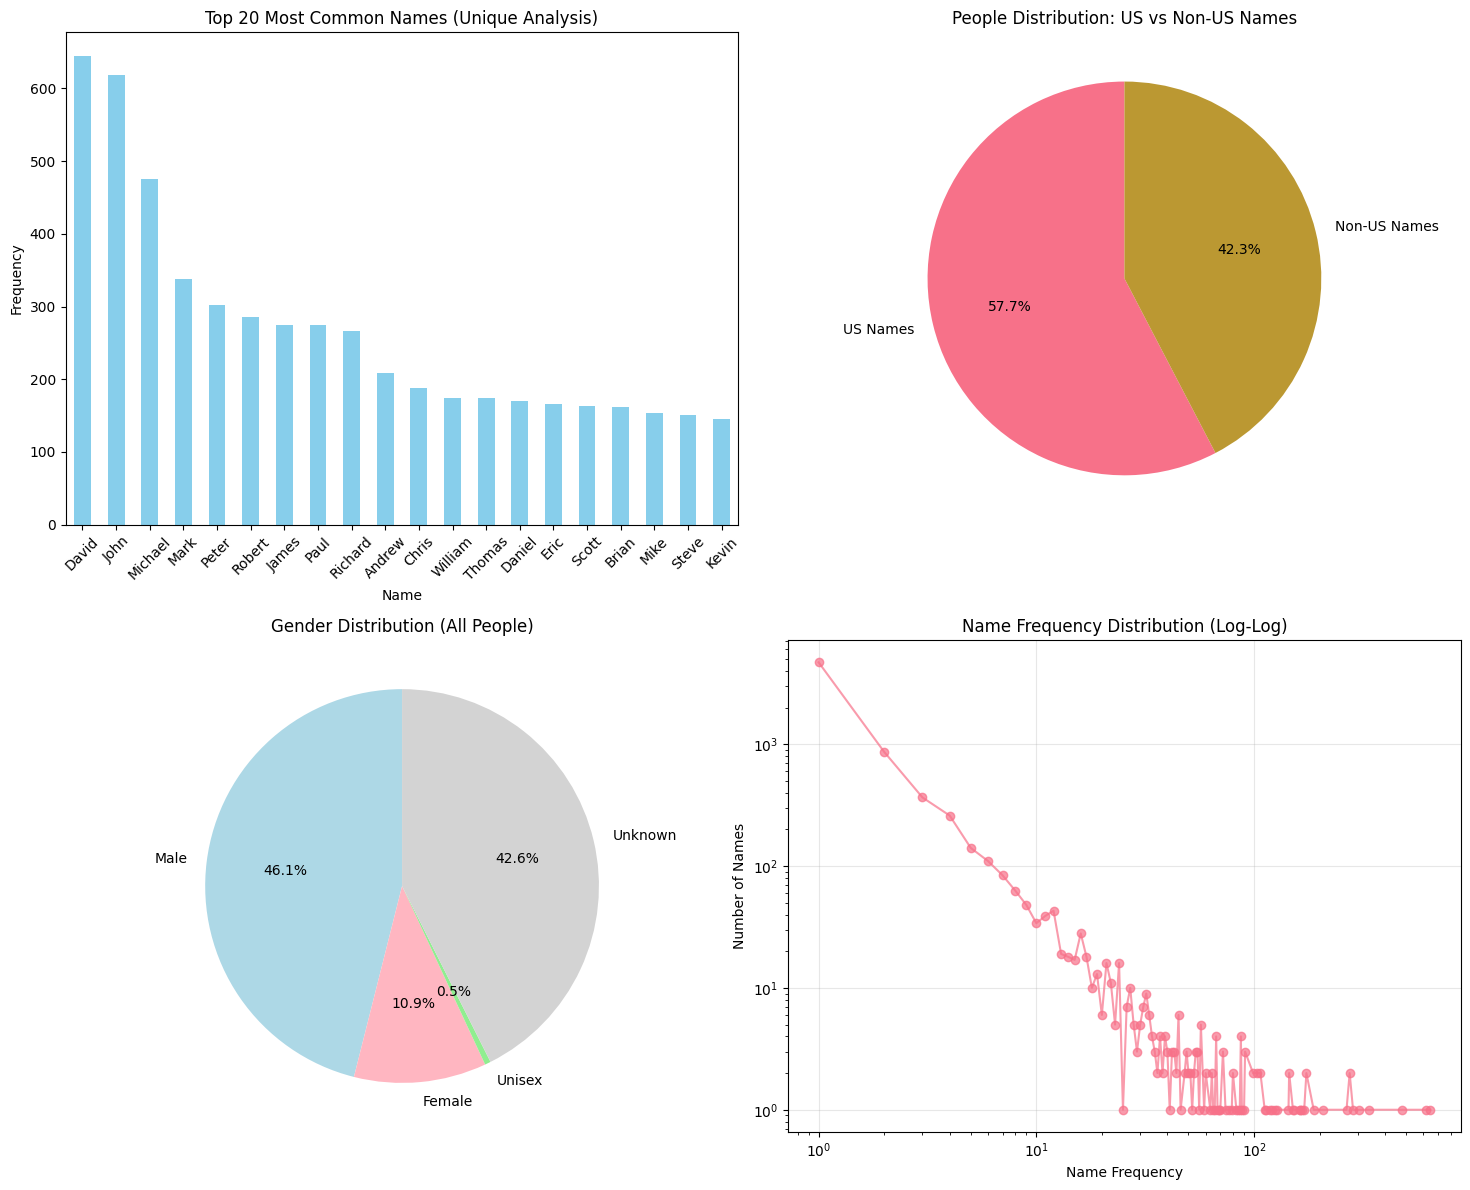

In [45]:
# Visualization for unique names analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Top 20 names
name_counts.head(20).plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Top 20 Most Common Names (Unique Analysis)')
ax1.set_xlabel('Name')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

# 2. US vs Non-US (people count)
us_nonus_data = [us_people_count, non_us_people_count]
labels = ['US Names', 'Non-US Names']
ax2.pie(us_nonus_data, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('People Distribution: US vs Non-US Names')

# 3. Gender distribution
gender_data = [male_people, female_people, unisex_people, unknown_people]
gender_labels = ['Male', 'Female', 'Unisex', 'Unknown']
colors = ['lightblue', 'lightpink', 'lightgreen', 'lightgray']
ax3.pie(gender_data, labels=gender_labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax3.set_title('Gender Distribution (All People)')

# 4. Name frequency distribution
freq_counts = name_counts.value_counts().sort_index()
ax4.loglog(freq_counts.index, freq_counts.values, 'o-', alpha=0.7)
ax4.set_xlabel('Name Frequency')
ax4.set_ylabel('Number of Names')
ax4.set_title('Name Frequency Distribution (Log-Log)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis 2: Grouped Name Analysis (With Variants)

Now let's define hard-coded rules to group name variants and analyze the distribution.

In [46]:
# Define name variant mappings (variant -> canonical)
NAME_VARIANTS = {
    # John family
    'Jon': 'John',
    'Johnny': 'John',
    'Jonathan': 'John',
    
    # Robert family  
    'Rob': 'Robert',
    'Bob': 'Robert',
    'Bobby': 'Robert',
    'Roberto': 'Robert',
    
    # William family
    'Bill': 'William',
    'Billy': 'William',
    'Willie': 'William',
    'Liam': 'William',
    
    # Michael family
    'Mike': 'Michael',
    'Mickey': 'Michael',
    'Miguel': 'Michael',
    
    # Richard family
    'Rick': 'Richard',
    'Ricky': 'Richard',
    'Rich': 'Richard',
    
    # James family
    'Jim': 'James',
    'Jimmy': 'James',
    'Jamie': 'James',
    
    # Thomas family
    'Tom': 'Thomas',
    'Tommy': 'Thomas',
    
    # Matthew family
    'Matt': 'Matthew',
    'Matty': 'Matthew',
    
    # Timothy family
    'Tim': 'Timothy',
    'Timmy': 'Timothy',
    
    # Christopher family
    'Chris': 'Christopher',
    'Christie': 'Christopher',
    
    # Joseph family
    'Joe': 'Joseph',
    'Joey': 'Joseph',
    'Jose': 'Joseph',
    
    # Daniel family
    'Dan': 'Daniel',
    'Danny': 'Daniel',
    
    # David family
    'Dave': 'David',
    'Davey': 'David',
    
    # Steven/Stephen family
    'Steve': 'Stephen',
    'Steven': 'Stephen',
    
    # Edward family
    'Ed': 'Edward',
    'Eddie': 'Edward',
    'Ted': 'Edward',  # Traditional nickname
    
    # Andrew family
    'Andy': 'Andrew',
    'Drew': 'Andrew',
    
    # Anthony family
    'Tony': 'Anthony',
    'Antonio': 'Anthony',
    
    # Philip family
    'Phil': 'Philip',
    'Philippe': 'Philip',
    
    # Charles family
    'Charlie': 'Charles',
    'Chuck': 'Charles',
    
    # Kenneth family
    'Ken': 'Kenneth',
    'Kenny': 'Kenneth',
    
    # Ronald family
    'Ron': 'Ronald',
    'Ronnie': 'Ronald',
    
    # Donald family
    'Don': 'Donald',
    'Donnie': 'Donald',
    
    # Douglas family
    'Doug': 'Douglas',
    'Dougie': 'Douglas',
    
    # Gregory family
    'Greg': 'Gregory',
    'Gregg': 'Gregory',
    
    # Jeffrey family
    'Jeff': 'Jeffrey',
    'Jeffery': 'Jeffrey',
    
    # Samuel family
    'Sam': 'Samuel',
    'Sammy': 'Samuel',
    
    # Benjamin family
    'Ben': 'Benjamin',
    'Benny': 'Benjamin',
    
    # Alexander family
    'Alex': 'Alexander',
    'Al': 'Alexander',
    
    # Nicholas family
    'Nick': 'Nicholas',
    'Nicky': 'Nicholas',
    
    # Joshua family
    'Josh': 'Joshua',
    
    # Jacob family
    'Jake': 'Jacob',
    
    # FEMALE NAMES
    
    # Elizabeth family
    'Liz': 'Elizabeth',
    'Beth': 'Elizabeth',
    'Betty': 'Elizabeth',
    'Betsy': 'Elizabeth',
    'Eliza': 'Elizabeth',
    
    # Katherine family
    'Kate': 'Katherine',
    'Katie': 'Katherine',
    'Kathy': 'Katherine',
    'Catherine': 'Katherine',
    'Kathryn': 'Katherine',
    'Cathy': 'Katherine',
    
    # Margaret family
    'Maggie': 'Margaret',
    'Meg': 'Margaret',
    'Peggy': 'Margaret',
    
    # Susan family
    'Sue': 'Susan',
    'Susie': 'Susan',
    'Suzanne': 'Susan',
    
    # Rebecca family
    'Becky': 'Rebecca',
    'Becca': 'Rebecca',
    
    # Jennifer family
    'Jen': 'Jennifer',
    'Jenny': 'Jennifer',
    
    # Patricia family
    'Pat': 'Patricia',
    'Patty': 'Patricia',
    'Patti': 'Patricia',
    
    # Christine family
    'Christie': 'Christine',
    'Christina': 'Christine',
    
    # Michelle family
    'Shelly': 'Michelle',
    'Shell': 'Michelle',
    
    # Abigail family
    'Abby': 'Abigail',
    'Abbie': 'Abigail',
    
    # Dorothy family
    'Dot': 'Dorothy',
    'Dotty': 'Dorothy',
    
    # Mary family (including variants)
    'Marie': 'Mary',
    'Maria': 'Mary',
    
    # Sarah family
    'Sara': 'Sarah',
    'Sally': 'Sarah',  # Traditional nickname
    
    # Caroline family
    'Carol': 'Caroline',
    'Carrie': 'Caroline',
    
    # Allison family
    'Alison': 'Allison'
}

print(f"Defined {len(NAME_VARIANTS)} name variant mappings")
print("\nSample mappings:")
for i, (variant, canonical) in enumerate(list(NAME_VARIANTS.items())[:10]):
    print(f"  {variant} → {canonical}")
print("  ...")

Defined 108 name variant mappings

Sample mappings:
  Jon → John
  Johnny → John
  Jonathan → John
  Rob → Robert
  Bob → Robert
  Bobby → Robert
  Roberto → Robert
  Bill → William
  Billy → William
  Willie → William
  ...


In [51]:
def normalize_name(name):
    """Convert name variant to canonical form"""
    return NAME_VARIANTS.get(name, name)

# Apply normalization
df['canonical_name'] = df['first_name'].apply(normalize_name)

# Count canonical names
canonical_counts = df['canonical_name'].value_counts()

print("=== GROUPED NAME ANALYSIS ===")
print(f"Total people: {len(df):,}")
print(f"Unique names (before grouping): {df['first_name'].nunique():,}")
print(f"Unique canonical names (after grouping): {df['canonical_name'].nunique():,}")
print(f"Names merged: {df['first_name'].nunique() - df['canonical_name'].nunique()}")

print(f"\nTop 20 canonical names:")
for i, (name, count) in enumerate(canonical_counts.head(20).items(), 1):
    # Check if this canonical name had variants merged
    variants = df[df['canonical_name'] == name]['first_name'].unique()
    variant_str = f" ({', '.join(variants)})" if len(variants) > 1 else ""
    in_ref = "✓" if name in all_us_names else "✗"
    print(f"{i:2d}. {name:12s}: {count:4d} [{in_ref}]{variant_str}")

=== GROUPED NAME ANALYSIS ===
Total people: 29,821
Unique names (before grouping): 7,126
Unique canonical names (after grouping): 7,026
Names merged: 100

Top 20 canonical names:
 1. John        :  827 [✓] (John, Jon, Jonathan, Johnny)
 2. David       :  702 [✓] (David, Dave)
 3. Michael     :  646 [✓] (Mike, Michael, Miguel, Mickey)
 4. Robert      :  455 [✓] (Robert, Rob, Bob, Bobby, Roberto)
 5. James       :  451 [✓] (James, Jamie, Jim, Jimmy)
 6. Stephen     :  410 [✓] (Steve, Steven, Stephen)
 7. Richard     :  342 [✓] (Richard, Rich, Rick, Ricky)
 8. Mark        :  338 [✓]
 9. Thomas      :  329 [✓] (Tom, Thomas, Tommy)
10. William     :  309 [✓] (Bill, William, Billy, Willie, Liam)
11. Peter       :  302 [✓]
12. Daniel      :  292 [✓] (Daniel, Danny, Dan)
13. Christopher :  287 [✓] (Chris, Christopher)
14. Andrew      :  279 [✓] (Andrew, Andy, Drew)
15. Paul        :  275 [✓]
16. Joseph      :  206 [✓] (Joe, Jose, Joseph, Joey)
17. Jeffrey     :  201 [✓] (Jeff, Jeffrey, Jeffery

### Understanding "Unique" vs "Grouped" Analysis

**Unique Analysis:**
- Treats each name variant as a **separate entity**
- Example: "John", "Jon", "Johnny", and "Jonathan" are counted as 4 different names
- This shows the raw distribution without merging variants

**Grouped Analysis:**
- Merges name variants into **canonical forms** using predefined mappings
- Example: "Jon", "Johnny", "Jonathan" → all grouped under "John"
- This provides a more consolidated view by combining nicknames/shortened forms with their full names
- Helps identify patterns that might be obscured when variants are split

**Why the difference matters:**
- Grouping can reveal that certain names are more common than they appear when split across variants
- For example, "John" might rank higher when "Jon" and "Johnny" are included
- The "Change" column shows how many people shift categories when variants are merged


In [52]:
# Show which name variants were reclassified from Unknown to Male/Female

print("=== EXPLANATION: Why Grouped > Unique ===")
print("\nWhen name variants are merged, some previously 'Unknown' names get reclassified:")
print("(because their canonical form IS in the US reference list)\n")

# Find names that were Unknown in unique but became Male/Female in grouped
unique_unknown_names = set(name_counts.index) - all_us_names
canonical_known_names = set(canonical_counts.index).intersection(all_us_names)

# Find variants that became known after grouping
reclassified_variants = []
for variant in unique_unknown_names:
    canonical = NAME_VARIANTS.get(variant, variant)
    if canonical in canonical_known_names:
        variant_count = name_counts.get(variant, 0)
        if variant_count > 0:
            category = 'Male' if canonical in male_names else 'Female' if canonical in female_names else 'Unisex'
            reclassified_variants.append({
                'variant': variant,
                'canonical': canonical,
                'count': variant_count,
                'category': category
            })

# Sort by count descending
reclassified_variants.sort(key=lambda x: x['count'], reverse=True)

print(f"Found {len(reclassified_variants)} name variants that were reclassified:\n")
print(f"{'Variant':<15} {'→ Canonical':<15} {'Count':>8} {'Category':<10}")
print("-" * 55)

male_reclassified = 0
female_reclassified = 0

for item in reclassified_variants[:30]:  # Show top 30
    print(f"{item['variant']:<15} → {item['canonical']:<12} {item['count']:>8} {item['category']:<10}")
    if item['category'] == 'Male':
        male_reclassified += item['count']
    elif item['category'] == 'Female':
        female_reclassified += item['count']

if len(reclassified_variants) > 30:
    print(f"\n... and {len(reclassified_variants) - 30} more variants")

print(f"\nSummary of reclassification:")
print(f"  Variants → Male names: {male_reclassified:,} people")
print(f"  Variants → Female names: {female_reclassified:,} people")
print(f"  Total reclassified: {male_reclassified + female_reclassified:,} people")
print(f"\nThis explains why:")
print(f"  Male: +{canonical_male_people - male_people:,} (some variants like 'Jon' → 'John')")
print(f"  Female: +{canonical_female_people - female_people:,} (some variants merged to recognized female names)")
print(f"  Unknown: {canonical_unknown_people - unknown_people:,} (people moved to Male/Female)")


=== EXPLANATION: Why Grouped > Unique ===

When name variants are merged, some previously 'Unknown' names get reclassified:
(because their canonical form IS in the US reference list)

Found 1 name variants that were reclassified:

Variant         → Canonical        Count Category  
-------------------------------------------------------
Al              → Alexander          10 Male      

Summary of reclassification:
  Variants → Male names: 10 people
  Variants → Female names: 0 people
  Total reclassified: 10 people

This explains why:
  Male: +91 (some variants like 'Jon' → 'John')
  Female: +155 (some variants merged to recognized female names)
  Unknown: -246 (people moved to Male/Female)


In [53]:
# Compare grouped vs unique analysis
print("=== COMPARISON: GROUPED vs UNIQUE ANALYSIS ===")
print()

# Show biggest gainers from grouping
print("Names with biggest gains from variant grouping:")
original_counts = df['first_name'].value_counts()
grouped_counts = df['canonical_name'].value_counts()

gains = {}
for canonical in grouped_counts.index:
    variants = df[df['canonical_name'] == canonical]['first_name'].unique()
    if len(variants) > 1:
        total_grouped = grouped_counts[canonical]
        original_main = original_counts.get(canonical, 0)
        gain = total_grouped - original_main
        gains[canonical] = {
            'total': total_grouped,
            'original': original_main,
            'gain': gain,
            'variants': variants
        }

# Sort by gain
sorted_gains = sorted(gains.items(), key=lambda x: x[1]['gain'], reverse=True)

for i, (name, info) in enumerate(sorted_gains[:15], 1):
    variants_str = ', '.join([v for v in info['variants'] if v != name])
    print(f"{i:2d}. {name:12s}: {info['original']:3d} → {info['total']:3d} (+{info['gain']:2d}) [{variants_str}]")

=== COMPARISON: GROUPED vs UNIQUE ANALYSIS ===

Names with biggest gains from variant grouping:
 1. Stephen     : 145 → 410 (+265) [Steve, Steven]
 2. John        : 618 → 827 (+209) [Jon, Jonathan, Johnny]
 3. Christopher :  99 → 287 (+188) [Chris]
 4. James       : 275 → 451 (+176) [Jamie, Jim, Jimmy]
 5. Michael     : 476 → 646 (+170) [Mike, Miguel, Mickey]
 6. Robert      : 285 → 455 (+170) [Rob, Bob, Bobby, Roberto]
 7. Thomas      : 174 → 329 (+155) [Tom, Tommy]
 8. William     : 174 → 309 (+135) [Bill, Billy, Willie, Liam]
 9. Daniel      : 170 → 292 (+122) [Danny, Dan]
10. Joseph      :  87 → 206 (+119) [Joe, Jose, Joey]
11. Katherine   :  27 → 141 (+114) [Catherine, Cathy, Kate, Katie, Kathy, Kathryn]
12. Jeffrey     :  91 → 201 (+110) [Jeff, Jeffery]
13. Alexander   :  64 → 157 (+93) [Alex, Al]
14. Benjamin    :  35 → 127 (+92) [Ben, Benny]
15. Timothy     :  40 → 130 (+90) [Tim]


In [54]:
# Gender distribution with grouping
canonical_us_names_in_data = set(canonical_counts.index).intersection(all_us_names)
canonical_non_us_names_in_data = set(canonical_counts.index) - all_us_names

canonical_male_people = canonical_counts[canonical_counts.index.isin(male_names)].sum()
canonical_female_people = canonical_counts[canonical_counts.index.isin(female_names)].sum()
canonical_unisex_people = canonical_counts[canonical_counts.index.isin(unisex_names)].sum()
canonical_unknown_people = len(df) - (canonical_male_people + canonical_female_people + canonical_unisex_people)

print("=== GENDER DISTRIBUTION COMPARISON ===")
print(f"{'':20s} {'Unique':>10s} {'Grouped':>10s} {'Change':>10s}")
print("-" * 55)
print(f"{'Male people':20s} {male_people:>10,} {canonical_male_people:>10,} {canonical_male_people - male_people:>+10,}")
print(f"{'Female people':20s} {female_people:>10,} {canonical_female_people:>10,} {canonical_female_people - female_people:>+10,}")
print(f"{'Unknown people':20s} {unknown_people:>10,} {canonical_unknown_people:>10,} {canonical_unknown_people - unknown_people:>+10,}")
print()

# Among classified only
original_classified = male_people + female_people
grouped_classified = canonical_male_people + canonical_female_people

if original_classified > 0 and grouped_classified > 0:
    orig_male_pct = male_people / original_classified * 100
    orig_female_pct = female_people / original_classified * 100
    group_male_pct = canonical_male_people / grouped_classified * 100
    group_female_pct = canonical_female_people / grouped_classified * 100
    
    print("Gender ratios (among US-classified names only):")
    print(f"  Unique analysis: {orig_male_pct:.1f}% Male, {orig_female_pct:.1f}% Female")
    print(f"  Grouped analysis: {group_male_pct:.1f}% Male, {group_female_pct:.1f}% Female")
    print(f"  Change: {group_male_pct - orig_male_pct:+.1f}% Male, {group_female_pct - orig_female_pct:+.1f}% Female")

=== GENDER DISTRIBUTION COMPARISON ===
                         Unique    Grouped     Change
-------------------------------------------------------
Male people              13,738     13,829        +91
Female people             3,240      3,395       +155
Unknown people           12,699     12,453       -246

Gender ratios (among US-classified names only):
  Unique analysis: 80.9% Male, 19.1% Female
  Grouped analysis: 80.3% Male, 19.7% Female
  Change: -0.6% Male, +0.6% Female


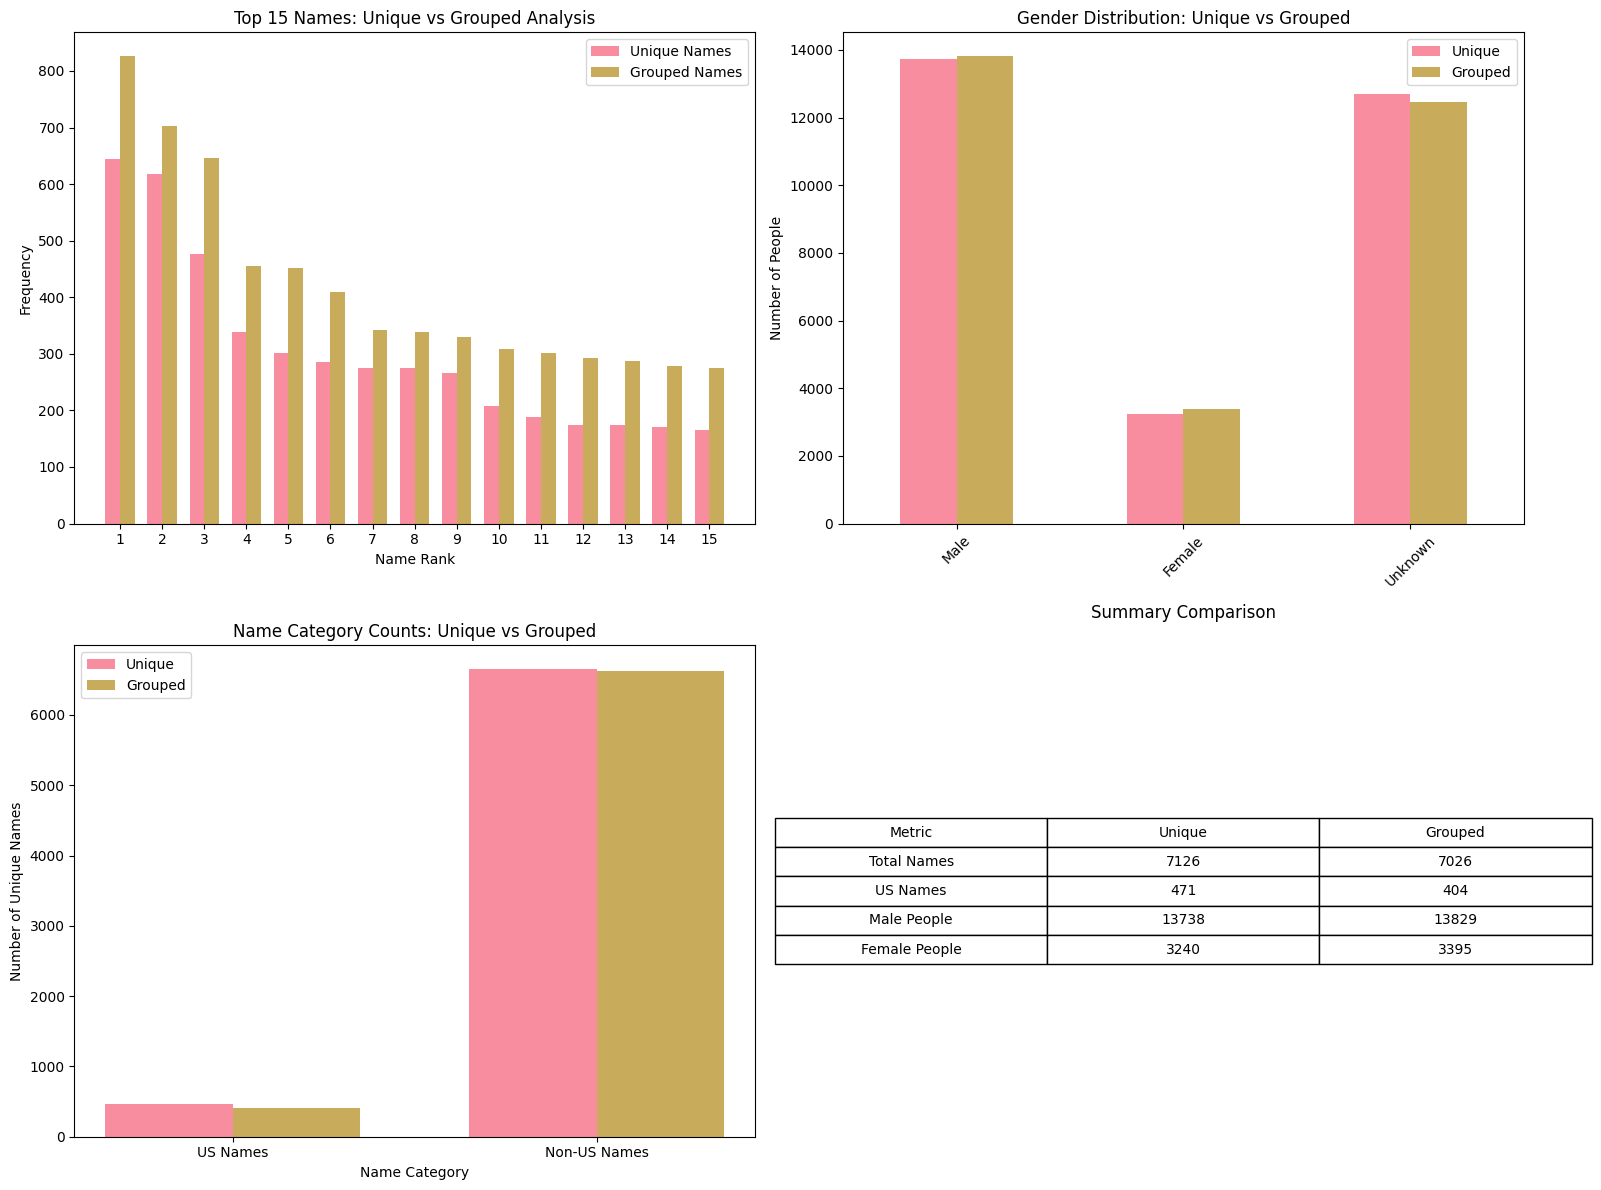

In [37]:
# Final comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top names comparison
top_unique = name_counts.head(15)
top_grouped = canonical_counts.head(15)

x = np.arange(len(top_unique))
width = 0.35

ax1.bar(x - width/2, top_unique.values, width, label='Unique Names', alpha=0.8)
ax1.bar(x + width/2, top_grouped.values, width, label='Grouped Names', alpha=0.8)
ax1.set_xlabel('Name Rank')
ax1.set_ylabel('Frequency')
ax1.set_title('Top 15 Names: Unique vs Grouped Analysis')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([f"{i+1}" for i in range(len(top_unique))])

# 2. Gender distribution comparison
gender_comparison = pd.DataFrame({
    'Unique': [male_people, female_people, unknown_people],
    'Grouped': [canonical_male_people, canonical_female_people, canonical_unknown_people]
}, index=['Male', 'Female', 'Unknown'])

gender_comparison.plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_title('Gender Distribution: Unique vs Grouped')
ax2.set_ylabel('Number of People')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# 3. Coverage improvement
coverage_data = [
    [len(us_names_in_data), len(canonical_us_names_in_data)],
    [len(non_us_names_in_data), len(canonical_non_us_names_in_data)]
]
categories = ['US Names', 'Non-US Names']
x = np.arange(len(categories))

ax3.bar(x - width/2, [coverage_data[0][0], coverage_data[1][0]], width, label='Unique', alpha=0.8)
ax3.bar(x + width/2, [coverage_data[0][1], coverage_data[1][1]], width, label='Grouped', alpha=0.8)
ax3.set_xlabel('Name Category')
ax3.set_ylabel('Number of Unique Names')
ax3.set_title('Name Category Counts: Unique vs Grouped')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend()

# 4. Summary stats
summary_data = [
    ['Total Names', df['first_name'].nunique(), df['canonical_name'].nunique()],
    ['US Names', len(us_names_in_data), len(canonical_us_names_in_data)],
    ['Male People', male_people, canonical_male_people],
    ['Female People', female_people, canonical_female_people]
]

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=summary_data, 
                  colLabels=['Metric', 'Unique', 'Grouped'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Summary Comparison', pad=20)

plt.tight_layout()
plt.show()

## Export Results

In [55]:
# Prepare final dataset with classifications

# Ensure canonical_name exists (create it if grouped analysis wasn't run)
if 'canonical_name' not in df.columns:
    print("⚠️  'canonical_name' column not found. Creating it now...")
    if 'NAME_VARIANTS' not in globals():
        print("⚠️  NAME_VARIANTS not found. Using first_name as canonical_name.")
        df['canonical_name'] = df['first_name']
    else:
        def normalize_name(name):
            """Convert name variant to canonical form"""
            return NAME_VARIANTS.get(name, name)
        df['canonical_name'] = df['first_name'].apply(normalize_name)
        print("✅ Created canonical_name column using NAME_VARIANTS mapping")

df['is_us_name'] = df['first_name'].isin(all_us_names)
df['is_canonical_us_name'] = df['canonical_name'].isin(all_us_names)
df['is_male'] = df['canonical_name'].isin(male_names)
df['is_female'] = df['canonical_name'].isin(female_names)
df['is_unisex'] = df['canonical_name'].isin(unisex_names)
df['gender_estimate'] = df.apply(lambda x: 
    'Male' if x['is_male'] else 
    'Female' if x['is_female'] else 
    'Unisex' if x['is_unisex'] else 
    'Unknown', axis=1)
df['has_variants'] = df['first_name'] != df['canonical_name']

# Export enhanced dataset
output_data = df.to_dict('records')
with open('entities_name_analysis.json', 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"✅ Exported {len(output_data)} records to 'entities_name_analysis.json'")
print("\nAdded columns:")
print("  - first_name: Extracted first name")
print("  - canonical_name: Name after variant grouping")
print("  - is_us_name: Whether original name is in US reference")
print("  - is_canonical_us_name: Whether canonical name is in US reference")
print("  - gender_estimate: Estimated gender (Male/Female/Unisex/Unknown)")
print("  - has_variants: Whether name was merged with variants")

# Create summary report
summary = {
    'total_entities': len(df),
    'unique_analysis': {
        'unique_names': df['first_name'].nunique(),
        'us_names': len(us_names_in_data),
        'non_us_names': len(non_us_names_in_data),
        'male_people': int(male_people),
        'female_people': int(female_people),
        'unknown_people': int(unknown_people)
    },
    'grouped_analysis': {
        'canonical_names': df['canonical_name'].nunique(),
        'us_names': len(canonical_us_names_in_data),
        'non_us_names': len(canonical_non_us_names_in_data),
        'male_people': int(canonical_male_people),
        'female_people': int(canonical_female_people),
        'unknown_people': int(canonical_unknown_people)
    },
    'variant_mappings_used': len(NAME_VARIANTS),
    'names_with_variants': int(df['has_variants'].sum())
}

with open('name_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Exported summary to 'name_analysis_summary.json'")
print("\n=== FINAL SUMMARY ===")
print(f"Names merged through variants: {df['first_name'].nunique() - df['canonical_name'].nunique()}")
print(f"People affected by grouping: {df['has_variants'].sum():,}")
print(f"Gender ratio improvement (Male): {group_male_pct - orig_male_pct:+.1f}%")
print(f"US name coverage: {len(canonical_us_names_in_data)}/{len(all_us_names)} = {len(canonical_us_names_in_data)/len(all_us_names)*100:.1f}%")

✅ Exported 29821 records to 'entities_name_analysis.json'

Added columns:
  - first_name: Extracted first name
  - canonical_name: Name after variant grouping
  - is_us_name: Whether original name is in US reference
  - is_canonical_us_name: Whether canonical name is in US reference
  - gender_estimate: Estimated gender (Male/Female/Unisex/Unknown)
  - has_variants: Whether name was merged with variants

✅ Exported summary to 'name_analysis_summary.json'

=== FINAL SUMMARY ===
Names merged through variants: 100
People affected by grouping: 3,586
Gender ratio improvement (Male): -0.6%
US name coverage: 404/538 = 75.1%


## Interactive Visualization: Full Name Distribution

The following cells create interactive charts for the full distribution of first names and export the complete results (all names), not just the top 20.


In [56]:
# Interactive visualization of all name frequencies (full distribution)
# Requires: plotly, ipywidgets (optional for slider)

# Imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

try:
    from ipywidgets import interact, IntSlider
    _widgets_available = True
except Exception:
    _widgets_available = False
    print("Note: ipywidgets not available; install with `pip install ipywidgets` to enable the Top-N slider.")

# Build dataframe of name counts (all names)
name_counts_df = (
    df['first_name']
      .value_counts()
      .rename_axis('first_name')
      .reset_index(name='count')
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# 1) All-names interactive bar chart (zoom/pan to explore)
fig_all = px.bar(
    name_counts_df,
    x='first_name',
    y='count',
    title='Name Frequencies (All Names - zoom to explore)',
    hover_data=['first_name', 'count'],
    height=600
)
fig_all.update_layout(xaxis_title='First Name', yaxis_title='Count')
fig_all.show()

# 2) Frequency-of-frequencies histogram (how many names occur X times)
fig_hist = px.histogram(
    name_counts_df,
    x='count',
    nbins=50,
    title='Distribution of Name Frequencies (Count-of-counts)',
)
fig_hist.update_layout(xaxis_title='Occurrences per Name', yaxis_title='Number of Names', yaxis_type='log')
fig_hist.show()

# 3) Interactive Top-N bar via slider (optional if ipywidgets installed)
def _plot_top_n(n):
    subset = name_counts_df.head(int(n))
    fig = px.bar(
        subset,
        x='first_name',
        y='count',
        title=f'Top {int(n)} Names',
        hover_data=['first_name', 'count'],
        height=500
    )
    fig.update_layout(xaxis_title='First Name', yaxis_title='Count')
    fig.show()

if _widgets_available:
    interact(_plot_top_n, n=IntSlider(min=10, max=int(min(1000, len(name_counts_df))), step=10, value=100, description='Top N'))
else:
    print("Top-N slider disabled (ipywidgets not installed). You can still use the full bar chart above.")



interactive(children=(IntSlider(value=100, description='Top N', max=1000, min=10, step=10), Output()), _dom_cl…

In [57]:
# Export full name counts and charts (complete results, not just top 20)
import plotly.express as px

# Ensure name_counts_df exists (recompute if needed)
if 'name_counts_df' not in globals():
    name_counts_df = (
        df['first_name']
          .value_counts()
          .rename_axis('first_name')
          .reset_index(name='count')
          .sort_values('count', ascending=False)
          .reset_index(drop=True)
    )

# Data exports
name_counts_df.to_csv('name_counts_full.csv', index=False)
name_counts_df.to_json('name_counts_full.json', orient='records')

# Chart exports (standalone HTML)
fig_all_export = px.bar(
    name_counts_df,
    x='first_name',
    y='count',
    title='Name Frequencies (All Names)',
    hover_data=['first_name', 'count'],
    height=600
)
fig_all_export.write_html('name_counts_bar_all.html', include_plotlyjs='cdn')

fig_hist_export = px.histogram(
    name_counts_df,
    x='count',
    nbins=50,
    title='Distribution of Name Frequencies (Count-of-counts)'
)
fig_hist_export.update_layout(yaxis_type='log')
fig_hist_export.write_html('name_counts_histogram.html', include_plotlyjs='cdn')

print("\N{white heavy check mark} Exported:")
print(" - name_counts_full.csv")
print(" - name_counts_full.json")
print(" - name_counts_bar_all.html")
print(" - name_counts_histogram.html")



✅ Exported:
 - name_counts_full.csv
 - name_counts_full.json
 - name_counts_bar_all.html
 - name_counts_histogram.html


In [ ]:
# Export CSVs with current classification (known names classified, unknowns marked as needing classification)
# This creates intermediate files that show progress

for chunk_info in all_names_data:
    chunk_file = chunk_info['file']
    output_file = chunk_file.replace('names_chunk_', 'names_labeled_').replace('.txt', '.csv')
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['name', 'gender', 'us_common'])
        
        for item in chunk_info['data']:
            gender = item['gender'] if item['gender'] else 'UNCLASSIFIED'
            writer.writerow([item['name'], gender, item['us_common']])
    
    print(f"✅ Created {output_file}")

print(f"\n✅ Created {len(all_names_data)} CSV files with initial classifications")
print(f"   Names with 'UNCLASSIFIED' gender need LLM classification")
print(f"\nNext step: Classify the {len(unknown_names_list):,} unknown names")

In [ ]:
# For this step, we'll need to manually classify unknowns or use an AI API
# Since we're working in a notebook, let's create a placeholder that will be filled with actual classifications

# First, let's examine a sample of unknown names to understand what we're dealing with
unknown_names_list = sorted(list(unknown_names_set))
print(f"Total unique unknown names: {len(unknown_names_list):,}\n")
print("Sample of unknown names (first 50):")
for i, name in enumerate(unknown_names_list[:50], 1):
    print(f"{i:3d}. {name}")

print("\n... (showing first 50 of {len(unknown_names_list):,} unknown names)")
print("\nTo proceed with classification, we need to classify these names.")
print("Option 1: Use Claude/LLM API to classify in batches")
print("Option 2: Create an intelligent classifier based on name knowledge")
print("Option 3: Export unknown names and manually classify them")

### Classify Unknown Names

Now we'll classify the unknown names. Since there are potentially thousands, we'll do this by:
1. Showing a sample of unknown names
2. Creating a classification dictionary for them
3. Applying classifications and exporting to CSV

Run the cell above first to see how many unknowns we have, then we'll proceed with classification.

In [ ]:
def extract_name_from_line(line):
    """Extract clean name from a line with potential line numbers"""
    line = line.strip()
    if not line:
        return None
    
    # Format: "  1234→Name" or just "Name"
    if '→' in line:
        name = line.split('→')[1].strip()
    else:
        # Remove leading numbers and whitespace
        name = re.sub(r'^\s*\d+\s+', '', line).strip()
    
    return name if name else None

# Process all chunk files and identify what needs classification
chunk_files = sorted(glob.glob('names_chunk_*.txt'))
print(f"Found {len(chunk_files)} chunk files\n")

all_names_data = []
unknown_names_set = set()

for chunk_file in chunk_files:
    print(f"Processing {chunk_file}...")
    chunk_data = []
    
    with open(chunk_file, 'r', encoding='utf-8') as f:
        for line in f:
            name = extract_name_from_line(line)
            if name:
                if name in us_names_lookup:
                    # Known name - use existing classification
                    chunk_data.append({
                        'name': name,
                        'gender': us_names_lookup[name]['gender'],
                        'us_common': us_names_lookup[name]['us_common'],
                        'source': 'reference'
                    })
                else:
                    # Unknown name - needs LLM classification
                    chunk_data.append({
                        'name': name,
                        'gender': None,
                        'us_common': 'uncommon',
                        'source': 'needs_classification'
                    })
                    unknown_names_set.add(name)
    
    all_names_data.append({
        'file': chunk_file,
        'data': chunk_data,
        'total': len(chunk_data),
        'known': sum(1 for d in chunk_data if d['source'] == 'reference'),
        'unknown': sum(1 for d in chunk_data if d['source'] == 'needs_classification')
    })
    
    print(f"  Total: {len(chunk_data):,} | Known: {all_names_data[-1]['known']:,} | Unknown: {all_names_data[-1]['unknown']:,}")

print(f"\n{'='*60}")
print(f"SUMMARY:")
print(f"  Total names across all chunks: {sum(c['total'] for c in all_names_data):,}")
print(f"  Known (in US reference): {sum(c['known'] for c in all_names_data):,}")
print(f"  Unknown (need classification): {sum(c['unknown'] for c in all_names_data):,}")
print(f"  Unique unknown names: {len(unknown_names_set):,}")

In [ ]:
import os
import glob

# Create US names lookup dictionary with gender info from our reference data
us_names_lookup = {}

# Add male names
for name in male_names:
    us_names_lookup[name] = {'gender': 'male', 'us_common': 'common'}

# Add female names
for name in female_names:
    us_names_lookup[name] = {'gender': 'female', 'us_common': 'common'}

# Add unisex names
for name in unisex_names:
    us_names_lookup[name] = {'gender': 'unisex', 'us_common': 'common'}

print(f"✅ Created lookup dictionary with {len(us_names_lookup)} US common names")
print(f"   Male: {len(male_names)}")
print(f"   Female: {len(female_names)}")
print(f"   Unisex: {len(unisex_names)}")

## Name Classification for Chunked Files (Hybrid Approach)

**Approach:**
1. Check if name exists in `common_us_names_updated.txt` → use that gender/US common classification
2. For unknown names → classify based on actual linguistic and cultural knowledge (not hard-coded rules)

This ensures we capture nuances and don't miss names due to rigid pattern matching.

In [ ]:
# Create US names lookup dictionary with gender info
us_names_lookup = {}

# Add male names
for name in male_names:
    us_names_lookup[name] = {'gender': 'male', 'us_common': 'common'}

# Add female names
for name in female_names:
    us_names_lookup[name] = {'gender': 'female', 'us_common': 'common'}

# Add unisex names
for name in unisex_names:
    us_names_lookup[name] = {'gender': 'unisex', 'us_common': 'common'}

print(f"Created lookup dictionary with {len(us_names_lookup)} US common names")
print(f"  Male: {len(male_names)}")
print(f"  Female: {len(female_names)}")
print(f"  Unisex: {len(unisex_names)}")

## Name Classification for Chunked Files

This section processes the chunked name files (names_chunk_*.txt) and classifies each name by:
1. **Gender**: male, female, or unisex
2. **US Common Status**: common (in our reference list) or uncommon

Names already in our US reference list get their gender from that data. For other names, we'll classify based on linguistic patterns and cultural knowledge.